<a href="https://colab.research.google.com/github/bhuttazain/Geospecial_Assignment-1-/blob/main/geospatial_assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: justify;">

## Programming Exercises Q1: Dataset Selection (Spatial Data)

### What is Geospatial Data?
Geospatial data is any data that contains information about a specific **location on the Earth’s surface**. It usually includes geographic coordinates (latitude/longitude) and may also include descriptive attributes (name, type, category, address, etc.).

### Selected Dataset
For this assignment, I selected a geospatial dataset from **OpenStreetMap (OSM)**, a global and publicly available geographic database maintained by contributors, and extracted the data using the **Overpass API**, which allows location-based queries such as searching within a specified radius around a point. Specifically, my dataset contains the locations and attributes of car showrooms and dealerships in the radius of 30KM around KFUPM, collected using OSM tags like **shop=car and amenity=car_dealer**.

This dataset is useful because it supports practical spatial analysis tasks such as identifying where dealerships are concentrated (hotspots), understanding commercial clustering patterns along major roads, and assisting in business location analysis and urban/commercial planning decisions.

### Study Area (Location and Radius)
- **Center location:** King Fahd University of Petroleum & Minerals (KFUPM), Saudi Arabia  
- **Coordinates used:** `(26.307, 50.1459)` (latitude, longitude)  
- **Search radius:** `30,000 meters (30 km)`

This radius captures KFUPM and nearby surrounding cities/areas where car dealerships commonly exist.

### Data Collection Method
The dataset is collected by sending an **Overpass query** to extract objects tagged as:
- `shop=car`  (car shops/showrooms)
- `amenity=car_dealer` (car dealerships)

The query includes three OSM object types:
- **node** (single point location)
- **way** (polygon/line feature; converted to center point using `out center`)
- **relation** (complex features; converted to center point using `out center`)

The query returns results in a GeoJSON-like structure (FeatureCollection), which is convenient for mapping and visualization.

### Attributes Collected
For each showroom/dealership, the following information is extracted (when available):
- `name` (e.g., showroom name)
- `brand` or `operator` (e.g., Toyota, Hyundai, etc.)
- `addr:*` or `address` (street/address fields)
- `phone` / `contact:phone`
- `website` / `contact:website`
- `latitude` and `longitude` (coordinates)
- `osm_id` (unique identifier)

These attributes provide both **spatial** (where it is) and **non-spatial** (what it is) information.

### Summary
The selected dataset is a **public geospatial dataset** from OpenStreetMap, collected via Overpass API for a defined study region around KFUPM. Each record includes geographic coordinates and descriptive attributes, making it suitable for multiple spatial visualizations and analysis (choropleth, cartogram, bubble, hexbin, heatmap, and clustering).


In [ ]:
!pip install overpass
import time
import overpass

# Because of the larger range (30KM) Try multiple endpoints and retry on server load/errors
ENDPOINTS = [
    "https://overpass-api.de/api/interpreter",
    "https://lz4.overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
]

# Define the location for the query (KFUPM)
LOCATION = (26.307, 50.1459)  # (lat, lon)
DISTANCE_M = 30000  # radius in meters

# Overpass query
overpass_query = f"""
(
  node["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  way["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  relation["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});

  node["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  way["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  relation["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
);
out center;
"""

def fetch_with_retries(query: str, endpoints: list[str], max_retries: int = 5, base_wait: int = 5):
    """
    Try each endpoint in order. For each endpoint, retry with linear backoff.
    Returns GeoJSON dict on success.
    Raises the last exception if all attempts fail.
    """
    last_exc: Exception | None = None

    for endpoint in endpoints:
        api = overpass.API(endpoint=endpoint, timeout=600)

        for attempt in range(1, max_retries + 1):
            try:
                return api.get(query)
            except Exception as e:
                last_exc = e
                time.sleep(base_wait * attempt)

    if last_exc is not None:
        raise last_exc
    raise RuntimeError("No endpoints provided.")

try:
    cars_showrooms = fetch_with_retries(overpass_query, ENDPOINTS)
except Exception as e:
    # fallback to empty FeatureCollection if all endpoints/retries fail
    cars_showrooms = {"type": "FeatureCollection", "features": []}
    print(f"Overpass query failed after retries: {e}")

# Optional: quick summary
print(f"Features returned: {len(cars_showrooms.get('features', []))}")



In [ ]:
cars_showrooms

<div style="text-align: justify;">

## **Data Extraction and Printing (Car Showrooms & Dealerships)**

### **Step 1: Set the study area**
I defined the center point of the study as **KFUPM** using its latitude and longitude, and selected a **30 km radius** around it. This helps limit the results to only the nearby region that I want to analyze.

### **Step 2: Load the Overpass API results**
After running the Overpass query, the results are stored in the variable `cars_showrooms`.  
This data is returned in a GeoJSON-like format where each place is stored as a **feature** inside:
- `cars_showrooms["features"]`

### **Step 3: Check the data (debugging)**
Before printing the list, I printed:
- the type of `cars_showrooms`,
- the available keys (to confirm the structure),
- and the number of features returned.

This step ensures the data is correctly collected and available for processing.

### **Step 4: Loop through all locations**
I used a loop to go through each feature one by one and assigned a **serial number** (`sr_no`) using `enumerate()`.  
This allows printing results in a numbered list format (1, 2, 3, ...).

### **Step 5: Extract key information from each feature**
For every showroom/dealership, I extracted important details such as:
- `name` (showroom name)
- `brand` (car brand or operator)
- `address` (if available)
- `phone` and `website` (if available)

Since OpenStreetMap data may not have all fields, I used **fallback values** like:
- `"Unnamed"` if name is missing,
- `"Unknown Brand"` if brand is missing,
- `"N/A"` if phone/website is missing.

### **Step 6: Extract coordinates (latitude and longitude)**
Each feature contains its geographic location in the `geometry` section.  
If the feature is a point, I extracted coordinates from:
- `geometry["coordinates"]`  
(GeoJSON stores it as **[longitude, latitude]**, so I assigned them correctly.)

### **Step 7: Save the cleaned results**
I stored each processed showroom/dealership into a list called `showrooms_locations`.  
This list creates a clean dataset that can later be used for visualization (heatmaps, choropleths, clustering, etc.).

### **Step 8: Print the results in list form**
Finally, I printed each showroom in a clear format with:
- serial number
- name
- brand
- latitude/longitude
- and other optional details (address, phone, website)

### **Step 9: Show summary statistics (brand distribution)**
At the end, I counted how many showrooms belong to each brand using `Counter`.  
This provides a quick idea of which car brands appear most frequently in the selected area.


In [ ]:

from collections import Counter

# Make sure these names match what you used earlier:
location = LOCATION        # or comment this if you already have location
distance = DISTANCE_M      # or comment this if you already have distance

print("\n" + "=" * 70)
print("LIST OF CAR SHOWROOMS & DEALERSHIPS")
print(f"Location: KFUPM ({location[0]}, {location[1]}) | Radius: {distance/1000:.1f}km")
print("=" * 70)

# --- DEBUG (helps confirming that we are reading the right data) ---
print("Debug: cars_showrooms type =", type(cars_showrooms))
print("Debug: keys =", list(cars_showrooms.keys()) if isinstance(cars_showrooms, dict) else "N/A")

features = cars_showrooms.get("features", []) if isinstance(cars_showrooms, dict) else []
print("Debug: number of features =", len(features))

showrooms_locations = []

if not features:
    print("\n⚠ No car showrooms found in this area (features list is empty).")
else:
    for sr_no, feature in enumerate(features, start=1):
        properties = feature.get("properties", {}) or {}
        geometry = feature.get("geometry", {}) or {}

        # Get name and brand
        name = properties.get("name") or "Unnamed"
        brand = properties.get("brand") or properties.get("operator") or "Unknown Brand"

        # Extra details
        address = (
            properties.get("addr:full")
            or properties.get("addr:street")
            or properties.get("address")
            or "Address not available"
        )
        phone = properties.get("phone") or properties.get("contact:phone") or "N/A"
        website = properties.get("website") or properties.get("contact:website") or "N/A"

        # Coordinates (GeoJSON Point)
        lat = lon = None
        if geometry.get("type") == "Point":
            coords = geometry.get("coordinates", [])
            if len(coords) >= 2:
                lon, lat = coords[0], coords[1]

        # If coords missing, still print entry (don’t silently skip)
        lat_str = f"{lat:.6f}" if isinstance(lat, (float, int)) else "N/A"
        lon_str = f"{lon:.6f}" if isinstance(lon, (float, int)) else "N/A"

        showrooms_locations.append({
            "sr_no": sr_no,
            "name": name,
            "brand": brand,
            "latitude": lat,
            "longitude": lon,
            "address": address,
            "phone": phone,
            "website": website,
            "osm_id": properties.get("@id") or properties.get("id") or feature.get("id") or "N/A",
        })

        # Print result (ALL)
        print(f"\n{sr_no}. {name}", flush=True)
        print(f"   🏢 Brand:    {brand}", flush=True)
        print(f"   📍 Location: {lat_str}, {lon_str}", flush=True)
        if address != "Address not available":
            print(f"   🏠 Address:  {address}", flush=True)
        if phone != "N/A":
            print(f"   📞 Phone:    {phone}", flush=True)
        if website != "N/A":
            print(f"   🌐 Website:  {website}", flush=True)

print("\n" + "=" * 70)
print(f"TOTAL SHOWROOMS FOUND: {len(showrooms_locations)}")
print("=" * 70)

# Summary by brand
brands = [s["brand"] for s in showrooms_locations if s["brand"] and s["brand"] != "Unknown Brand"]
if brands:
    print("\nBrand Distribution:")
    for brand, count in Counter(brands).most_common():
        print(f"  • {brand}: {count}")




<div style="text-align: justify;">

## **Converting the Collected Locations into a DataFrame**

In this step, I converted the extracted showroom/dealership records stored in `showrooms_locations` into a **Pandas DataFrame** for easier analysis and visualization. First, I installed and imported the `pandas` library. Then, I created a DataFrame using `pd.DataFrame(showrooms_locations)`, where each dictionary becomes a row and each key becomes a column (e.g., name, brand, latitude, longitude, etc.). After that, I removed any rows with missing geographic coordinates using `dropna(subset=["latitude", "longitude"])` because valid latitude and longitude values are required for all spatial visualizations (maps, heatmaps, hexbin, clustering). Finally, I displayed a preview using `df.head()` and checked the total number of valid records using `len(df)`.


In [ ]:
!pip -q install pandas

import pandas as pd

df = pd.DataFrame(showrooms_locations).copy()

# keep only valid points
df = df.dropna(subset=["latitude", "longitude"])
df.head(), len(df)


<div style="text-align: justify;">

## **Question 2 : Spatial Data Visualization and Insights**

### **Purpose**
The main purpose of this part is to **visualize the collected geospatial dataset** (car showrooms and dealerships around KFUPM) in multiple spatial formats. Visualization helps transform raw latitude/longitude points into meaningful patterns, making it easier to understand **where the showrooms are concentrated**, how they are distributed across the city, and whether they form **clusters or hotspots** along important roads or commercial areas. In this task, I used six common spatial visualization techniques: **choropleth map, cartogram map, bubble map, hexagonal binning, heat map, and cluster map**.

### **How I did it (overall process)**
1. **Prepared the dataset**  
   After collecting the Overpass API results, I stored the cleaned showroom records in `showrooms_locations`.  
   Then I converted them into a Pandas DataFrame (`df`) and removed any rows with missing latitude/longitude so that every record has valid coordinates, as explained in above step

2. **Created geospatial objects for mapping**  
   For visualizations that required mapping and basemaps, I converted the DataFrame into a **GeoDataFrame** (using GeoPandas) and projected the data into **EPSG:3857** so that it aligns correctly with OpenStreetMap basemaps.

3. **Visualized the data using different methods (one by one)**  
   For each method, I used the simplest possible library setup:
   - Matplotlib / GeoPandas for static plots (choropleth, cartogram, hexbin)
   - Contextily for adding basemap tiles
   - Folium plugins for interactive maps (heat map and cluster map)

4. **Reported observations and insights**  
   After each visualization, I added a markdown cell to explain what the map shows and what patterns can be observed.

## **Visualizations and Observations**

### **1) Choropleth-style Map (Grid-based)**
**What it shows:**  
The choropleth-style grid map divides the study area into equal-sized grid cells (e.g., 3 km × 3 km) and colors each cell based on how many showrooms fall inside it.

In [ ]:
!pip -q install geopandas shapely pyproj matplotlib contextily

import geopandas as gpd
from shapely.geometry import Point, box
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

# GeoDataFrame (lat/lon)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Project to Web Mercator for basemap
gdf_m = gdf.to_crs(epsg=3857)

# Grid size
cell_size = 3000  # meters (3 km)
xmin, ymin, xmax, ymax = gdf_m.total_bounds

# Padding around data
pad = 5000
xmin, ymin, xmax, ymax = xmin - pad, ymin - pad, xmax + pad, ymax + pad

# Create grid
cols = np.arange(xmin, xmax + cell_size, cell_size)
rows = np.arange(ymin, ymax + cell_size, cell_size)

polys = [box(x0, y0, x0 + cell_size, y0 + cell_size) for x0 in cols[:-1] for y0 in rows[:-1]]
grid = gpd.GeoDataFrame({"geometry": polys}, crs=gdf_m.crs)

# Count points per cell
joined = gpd.sjoin(gdf_m, grid, predicate="within", how="left")
counts = joined.groupby("index_right").size()

grid["count"] = 0
grid.loc[counts.index, "count"] = counts.values

# Keep only non-empty cells
grid_nz = grid[grid["count"] > 0].copy()

# ---- Plot ONE map (with basemap) ----
fig, ax = plt.subplots(figsize=(8, 8))

grid_nz.plot(
    ax=ax,
    column="count",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    alpha=0.6
)

gdf_m.plot(ax=ax, markersize=10)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Choropleth-style Grid + Basemap (cell={cell_size/1000:.1f} km)")
ax.set_axis_off()
plt.show()




<div style="text-align: justify;">

### Insights & Observations

- The colored grid cells represent how many car showrooms/dealerships fall inside each **3 km × 3 km** area. Darker/brighter cells indicate **higher concentration**.
- The map shows a **clear hotspot** in the eastern/coastal side (the brightest cell), meaning many showrooms are located very close to each other in that commercial zone.
- Several medium-density cells appear around central parts of the city, which suggests there are **secondary dealership zones** besides the main hotspot.
- Most cells with showrooms are in **Al Rakah Al Janubiyah and in Al Khobar** located near **major roads and intersections**, which indicates dealerships prefer locations with high accessibility and visibility for customers.
- A few isolated low-density cells (single or small counts) appear farther from the main clusters, suggesting some dealerships are **scattered** outside the primary commercial district.
- Overall, the distribution is **not uniform**: showrooms are concentrated in specific corridors/areas rather than being evenly spread across the region.



<div style="text-align: justify;">

### 2) Cartogram Map (Scaled Symbols per Grid Cell)
**What it shows:**  
Instead of coloring grid cells, the cartogram-like map places circles at grid centroids and scales their size according to the number of showrooms in that grid cell.

In [ ]:

import contextily as ctx
import matplotlib.pyplot as plt

# Create centroids from grid_nz
centroids = grid_nz.copy()
centroids["geometry"] = centroids.geometry.centroid

fig, ax = plt.subplots(figsize=(8, 8))

# draw grid lightly for reference
grid_nz.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.3)

# plot scaled centroid markers
centroids.plot(ax=ax, markersize=centroids["count"] * 25, alpha=0.7)

# basemap (requires EPSG:3857, which we already have)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Cartogram-like Map (Scaled Symbols per Grid Cell) + Basemap")
ax.set_axis_off()
plt.show()


<div style="text-align: justify;">

**Insights observed:**
- The largest circles represent **dominant showroom zones**.
- If one circle is much larger than others, it suggests the market is **centralized** in one major district.
- Multiple medium circles indicate **multiple commercial hubs** rather than one single center.
- With basemap, it becomes easier to link high-density areas to main roads and central districts.

---


### 3) Bubble Map

**What it shows:**  
Each showroom is represented as a circle marker (bubble). Bubble size can be scaled using a variable (e.g., brand frequency), which helps compare dominance.

In [ ]:
!jupyter trust "geospatial_assigment.ipynb"
#!pip -q install folium

import folium
import math

center = [df["latitude"].mean(), df["longitude"].mean()]
m_bubble = folium.Map(location=center, zoom_start=11)

brand_counts = df["brand"].value_counts()

for _, row in df.iterrows():
    brand = row["brand"]
    count = int(brand_counts.get(brand, 1))
    radius = 3 + 2 * math.sqrt(count)   # simple scaling

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=radius,
        fill=True,
        fill_opacity=0.5,
        popup=f"{row['name']}<br>Brand: {brand}<br>Brand count: {count}"
    ).add_to(m_bubble)

m_bubble




<div style="text-align: justify;">

### Insights observed

- Each bubble represents a **car showroom/dealership location**, and the bubble size reflects the chosen scaling factor (e.g., how frequently a brand appears or the weight assigned in the visualization).
- The largest bubbles appear mainly along the **Al Rakah Al Janubiyah and in Al Khobar**, showing that this area has the strongest presence and activity related to car showrooms/dealers.
- Several medium bubbles are visible around central areas, indicating **secondary commercial zones** where dealerships also exist but with lower concentration than the main hotspot.
- The distribution is clearly **clustered rather than uniform**: bubbles are concentrated along major roads and key intersections, suggesting dealerships prefer locations with high accessibility and customer traffic.
- A few smaller and isolated bubbles appear farther away from the main corridor, which suggests some dealerships operate as **standalone locations** outside the primary market area.


<div style="text-align: justify;">

### 4) Hexagonal Binning
**What it shows:**  
Hexagonal binning groups points into hexagon cells and colors them by density. It is useful when points overlap and are hard to see individually.


In [ ]:

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Make a GeoDataFrame from df (lat/lon)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Project to EPSG:3857 for basemap
gdf_m = gdf.to_crs(epsg=3857)

# Hexbin + basemap
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_m.geometry.x,
    gdf_m.geometry.y,
    gridsize=35,
    mincnt=1
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Hexagonal Binning (Density) + Basemap")
ax.set_axis_off()
fig.colorbar(hb, ax=ax, label="Count per hexagon")
plt.show()


<div style="text-align: justify;">

**Insights observed:**
- Each hexagon represents a small area, and its color shows the **number of showrooms/dealers inside that hexagon**. Brighter colors indicate **higher density**.
- The map highlights a **strong hotspot on the eastern/coastal side** near **Al Rakah Al Janubiyah and in Al Khobar**, where the brightest hexagons appear. This suggests many dealerships are concentrated in a single commercial zone.
- Most other hexagons are low to medium density and appear along major road corridors, indicating showrooms tend to locate near **high-access routes and intersections**.
- The density pattern is **not uniform**: instead of being evenly spread, the dealerships form **clusters** with one dominant hotspot and several smaller pockets.
- A few isolated hexagons appear away from the main hotspot, showing that some dealerships exist as **standalone locations** outside the primary commercial district.


<div style="text-align: justify;">

### 5) Heat Map
**What it shows:**  
Heat maps highlight point density using a smooth color surface, making it easy to identify hotspots without focusing on individual points.


In [ ]:
import folium
from folium.plugins import HeatMap

center = [df["latitude"].mean(), df["longitude"].mean()]
m_heat = folium.Map(location=center, zoom_start=11)

HeatMap(df[["latitude", "longitude"]].values.tolist(), radius=18, blur=15).add_to(m_heat)

m_heat

<div style="text-align: justify;">

### Insights observed

- The heat map highlights **density** of car showrooms/dealerships using color intensity:  
  **red/yellow = highest concentration**, **green/blue = moderate to low concentration**.
- The strongest hotspot appears in the **Al Khobar coastal / Corniche side**, showing that many dealerships are located close together in that area.
- The heat pattern forms a corridor-like shape along major roads, especially around **King Fahd Road / King Fahd Service Road**, which suggests dealerships prefer locations with **high traffic flow and easy access**.
- Smaller hotspots appear in a few other locations, indicating **secondary commercial zones** where dealerships are present but less concentrated.
- Overall, the distribution is **clustered rather than uniform**, meaning dealerships tend to group in specific business corridors instead of spreading evenly across the city.



<div style="text-align: justify;">

### 6) Cluster Map
**What it shows:**  
Cluster maps group nearby markers together and expand when zooming in. This reduces clutter and allows interactive exploration of individual records.


In [ ]:
import folium
from folium.plugins import MarkerCluster

center = [df["latitude"].mean(), df["longitude"].mean()]
m_cluster = folium.Map(location=center, zoom_start=11)

cluster = MarkerCluster().add_to(m_cluster)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['name']}<br>Brand: {row['brand']}"
    ).add_to(cluster)

m_cluster


<div style="text-align: justify;">

### Insights observed

- The cluster map groups nearby showrooms/dealerships into **clusters** to reduce clutter and make the map easier to read.
- The numbers inside the circles represent **how many locations** are contained in that cluster at the current zoom level.
- A very large cluster (e.g., around **60 locations**) appears along the **Al Rakah Al Janubiyah**, showing that most dealerships are concentrated in that main commercial corridor.
- A second notable cluster (e.g., around **18 locations**) appears further south along the same coastal side in **Al Khobar**, indicating another **secondary hub**.
- Smaller clusters (2–8 locations) appear in other parts of the city, suggesting **scattered or smaller dealership groups** outside the main hotspot.
- Overall, the cluster map confirms that dealerships are **highly clustered** in specific areas rather than evenly distributed across the region.


<div style="text-align: justify;">

## **Final Summary (Overall Insights)**
From all visualizations, the overall pattern suggests that car showrooms and dealerships around KFUPM are **not evenly distributed**. Instead, they form clear **hotspots** and **clusters**, mostly concentrated near major roads and commercial centers. Choropleth, hexbin, and heat maps consistently show the same high-density areas, while cartogram and cluster maps provide an easier way to compare the strength of each hotspot and explore individual locations. These insights can support real-world decisions such as identifying the best areas for marketing, selecting potential new showroom locations, or understanding how commercial services are organized spatially in the region.

</div>

<div style="text-align: justify;">

## **Part II: Question 3 : Adding Points of Interest (POIs) on the Map**

### **Purpose**
The purpose of this task is to select **two important locations (points of interest)** in Saudi Arabia and highlight them on a map using **markers**. Adding POI markers helps provide geographic context and makes the map more informative by clearly showing key reference locations.

### **What I did**
- I selected **two well-known points of interest** in Saudi Arabia.
- For each POI, I collected its **latitude and longitude**.
- I then added **map markers** at those coordinates using a mapping library (Folium).
- Each marker includes a **label/popup** so that the location name is visible when the marker is clicked.

### **Expected output**
The final map shows two distinct markers that clearly highlight the selected points of interest, making it easy to locate them visually on the map.

</div>

In [ ]:
import folium

# ---- POIs ----
kfupm = (26.3070, 50.1459)  # KFUPM (lat, lon)

# Find Lamborghini showroom from your collected data (by name/brand)
lambo_df = df[df["name"].str.contains("Lamborghini", case=False, na=False) |
             df["brand"].str.contains("Lamborghini", case=False, na=False)]

if lambo_df.empty:
    raise ValueError("Lamborghini showroom not found in df. Check spelling or brand/name in your dataset.")

lambo_lat = float(lambo_df.iloc[0]["latitude"])
lambo_lon = float(lambo_df.iloc[0]["longitude"])
lamborghini_showroom = (lambo_lat, lambo_lon)

# --- Define uppercase variables for consistency with later code ---
KFUPM = kfupm
LAMBO = lamborghini_showroom

# ---- Map ----
center = [(kfupm[0] + lamborghini_showroom[0]) / 2, (kfupm[1] + lamborghini_showroom[1]) / 2]
m = folium.Map(location=center, zoom_start=12)

# KFUPM marker
folium.Marker(
    location=kfupm,
    popup="KFUPM (King Fahd University of Petroleum & Minerals)",
    tooltip="King Fahd University of Petroleum & Minerals",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa")
).add_to(m)

# Lamborghini showroom marker
lambo_name = lambo_df.iloc[0]["name"]
folium.Marker(
    location=lamborghini_showroom,
    popup=f"Lamborghini/Bentley showrooms: {lambo_name}",
    tooltip="Lamborghini/Bentley showrooms",
    icon=folium.Icon(color="red", icon="car", prefix="fa")
).add_to(m)

m


<div style="text-align: justify;">

### **POI Markers**
- The map highlights **KFUPM** as the reference location and the **Lamborghini / Bentley showrooms** as a selected point of interest from the collected dataset.
- Markers make it easy to visually compare where the showroom is located relative to KFUPM and observe the approximate distance and direction.

</div>

<div style="text-align: justify;">

## **Question 4 — Routing Between Two Points Using Different Algorithms (BFS, DFS, Dijkstra, Simulated Annealing)**

### **Purpose**
The purpose of this task is to **find and visualize routes** between the two selected points of interest (**KFUPM** and **Lamborghini/Bentley Showrooms**) using multiple routing algorithms. After generating the routes, the algorithms are compared based on:
- **Time taken** to compute the route, and
- **Cost**, measured as **total route length (in meters)**.

### **What I did**
To solve this problem, I treated the road network as a **graph**:
- **Intersections / road nodes** are graph nodes.
- **Road segments** connecting intersections are graph edges.
- Each edge has a **weight** (distance in meters), which represents the travel cost.

### **How I did it**
1. **Downloaded the road network**
   I downloaded the road network around the study area using OpenStreetMap road data. This provides the real-world streets and intersections needed for routing.

2. **Converted the road network into a graph**
   I represented the roads as a graph where each road segment is an edge and its length (meters) is used as edge weight.

3. **Mapped both POIs to nearest road nodes**
   Since the points (KFUPM and showroom) are given in latitude/longitude, I found the **nearest nodes** on the road graph to use as the start and destination.

4. **Computed routes using multiple algorithms**
   I calculated a route between the start and destination using:
   - **BFS (Breadth-First Search)**  
   - **DFS (Depth-First Search)**  
   - **Dijkstra’s Algorithm**  
   - **Simulated Annealing (Approximate Optimization Approach)**  

5. **Measured performance**
   For each algorithm, I computed:
   - the **runtime** (execution time in seconds), and
   - the **route length** (sum of edge lengths in meters).

6. **Rendered routes on a map**
   I plotted the computed paths on a map so the route shapes can be visually compared.

7. **Compared results**
   Finally, I summarized the results in a small comparison table showing time and route length for each method.

</div>


<div style="text-align: justify;">

## **Step 1 — Road Network Graph Preparation**

In this step, I prepared the road network required for routing. First, I defined two points of interest (POIs): **KFUPM** and the **Lamborghini/Bentley showroom** (retrieved from the collected dataset). Then, I downloaded the real road network from **OpenStreetMap** using the **OSMnx** library with `network_type="drive"` so the graph represents drivable roads. After the road network was converted into a graph, I mapped each POI to its **nearest road node** because routing algorithms work on graph nodes, not raw latitude/longitude coordinates. Finally, I displayed a map with markers for both POIs and their nearest road nodes to confirm that the start and end points are correctly placed for the routing algorithms.

</div>


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.9 MB/s eta 0:00:00
✅ Graph created
Nodes: 53726
Edges: 137554
✅ Converted to nodes/edges GeoDataFrames
nodes_gdf: (53726, 6) | edges_gdf: (137554, 15)


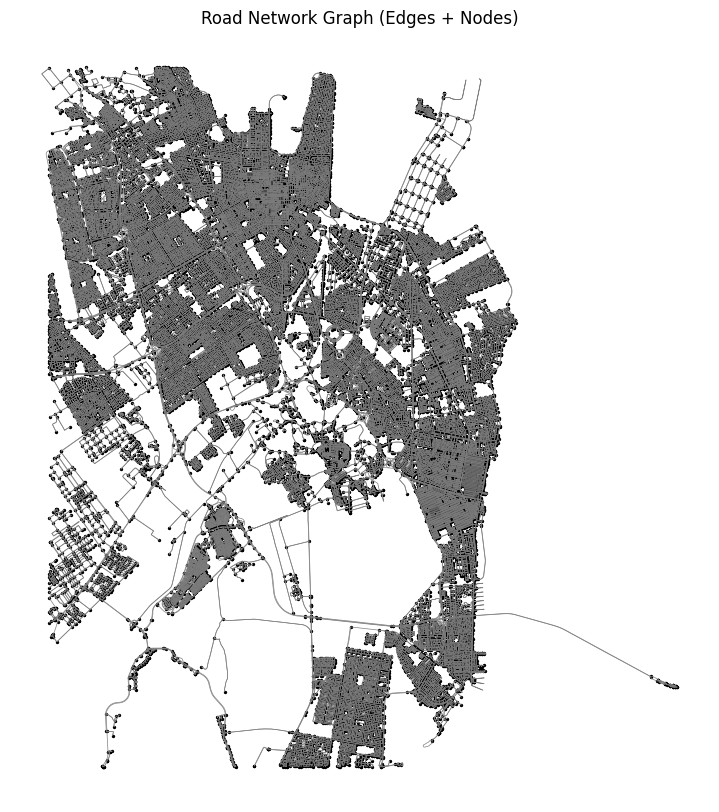

In [12]:
!pip -q install osmnx networkx matplotlib scikit-learn

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# 1) Build the drivable road network graph around midpoint
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

DIST_GRAPH = 20000  # meters (increase if needed)

ox.settings.use_cache = True
ox.settings.log_console = False

G = ox.graph_from_point(
    (center_lat, center_lon),
    dist=DIST_GRAPH,
    network_type="drive",
    simplify=True
)

# Add edge lengths (meters)
G = ox.distance.add_edge_lengths(G)

print("✅ Graph created")
print("Nodes:", len(G.nodes))
print("Edges:", len(G.edges))

# 2) Convert to nodes/edges GeoDataFrames (optional, but useful)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
print("✅ Converted to nodes/edges GeoDataFrames")
print("nodes_gdf:", nodes_gdf.shape, "| edges_gdf:", edges_gdf.shape)

# 3) Plot edges + nodes (simple black/white network view)
fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf.plot(ax=ax, linewidth=0.5, color="gray")
nodes_gdf.plot(ax=ax, markersize=2, color="black")
ax.set_title("Road Network Graph (Edges + Nodes)")
ax.set_axis_off()
plt.show()

## Helper functions (route length + safe edge length)

In [13]:
def route_length_m(G, route):
    """
    Sum of road segment lengths (meters) along a route.
    Works with MultiDiGraph by selecting the shortest edge among parallel edges.
    Handles routes from undirected graphs by checking both (u,v) and (v,u) directions.
    """
    total = 0.0
    for u, v in zip(route[:-1], route[1:]):
        # Try (u,v) first
        data = G.get_edge_data(u, v)
        if data:
            # MultiDiGraph, data is a dictionary of edge attributes for parallel edges
            total += min(attr.get("length", float("inf")) for attr in data.values())
        else:
            # If no (u,v) edge, try (v,u) for routes from undirected graphs
            data = G.get_edge_data(v, u)
            if data:
                total += min(attr.get("length", float("inf")) for attr in data.values())
            else:
                # No edge in either direction, path is invalid for G
                return float("inf")
    return total


def nearest_node(G, lat, lon):
    """
    Find the nearest road-network node to a (lat, lon) point.
    """
    return ox.distance.nearest_nodes(G, X=lon, Y=lat)


In [14]:
%pip install -q scikit-learn

# osmnx already imported earlier in the notebook; don't re-import it here
def nearest_node(G, lat, lon):
    """Find nearest node in graph G to coordinates (lat, lon)."""
    return ox.distance.nearest_nodes(G, X=lon, Y=lat)

# Now your calls will work (scikit-learn is installed for unprojected searches)
start_node = nearest_node(G, KFUPM[0], KFUPM[1])
goal_node = nearest_node(G, LAMBO[0], LAMBO[1])

print("Start node:", start_node)
print("Goal node:", goal_node)

# Convert to undirected for BFS/DFS
G_u = G.to_undirected()

Start node: 6582857339
Goal node: 3906878161


In [15]:
t0 = time.perf_counter()
bfs_route = nx.shortest_path(G_u, start_node, goal_node)  # unweighted shortest path
t1 = time.perf_counter()

bfs_time = t1 - t0
bfs_len  = route_length_m(G, bfs_route)

bfs_time, bfs_len


(0.0199613410000552, np.float64(9641.38867860493))

<div style="text-align: justify;">

## Part 2 — Mapping Start and End Points to Road Network Nodes

In this step, I prepared the road network for routing by converting the two selected POIs into valid graph nodes. Since routing algorithms operate on the road graph, I used a nearest-node search to **snap** each POI (KFUPM and the Lamborghini/Bentley showroom) to the closest road-network node. After that, I displayed the full road network on an interactive map, and added markers for both the **original POI coordinates** as well as the **snapped start and end road nodes**. This confirms that the routing algorithms will start and end on the road network instead of using raw latitude/longitude values.

</div>


In [ ]:
# Part 2: Snap start/end points to nearest road nodes + show them on the road network map

!pip -q install folium

import folium
import osmnx as ox

# Assumes Part 1 already ran and you already have:
# G, nodes_gdf, edges_gdf
# KFUPM = (lat, lon)
# LAMBO = (lat, lon)

# 1) Find nearest road nodes
start_node = nearest_node(G, KFUPM[0], KFUPM[1])
end_node   = nearest_node(G, LAMBO[0], LAMBO[1])

start_lat, start_lon = G.nodes[start_node]["y"], G.nodes[start_node]["x"]
end_lat, end_lon     = G.nodes[end_node]["y"], G.nodes[end_node]["x"]

print("Start node ID:", start_node, "->", (start_lat, start_lon))
print("End node ID:", end_node, "->", (end_lat, end_lon))

# 2) Create a Folium map centered between the points
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 3) Draw ALL edges (roads) on the map
# Convert edges to EPSG:4326 for Folium if needed
edges_4326 = edges_gdf.to_crs(epsg=4326)

for _, row in edges_4326.iterrows():
    geom = row.geometry
    if geom is None:
        continue

    # LineString -> list of (lat, lon)
    if geom.geom_type == "LineString":
        coords = [(lat, lon) for lon, lat in geom.coords]
        folium.PolyLine(coords, weight=2, opacity=0.6).add_to(m)

    # MultiLineString -> multiple LineStrings
    elif geom.geom_type == "MultiLineString":
        for line in geom.geoms:
            coords = [(lat, lon) for lon, lat in line.coords]
            folium.PolyLine(coords, weight=2, opacity=0.6).add_to(m)

# 4) Add markers for ORIGINAL points (from Part 3)
folium.Marker(
    [KFUPM[0], KFUPM[1]],
    tooltip="KFUPM (original point)",
    popup=f"KFUPM<br>Lat,Lon: {KFUPM[0]:.6f}, {KFUPM[1]:.6f}",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa")
).add_to(m)

folium.Marker(
    [LAMBO[0], LAMBO[1]],
    tooltip="Lamborghini/Bentley (original point)",
    popup=f"Lamborghini/Bentley<br>Lat,Lon: {LAMBO[0]:.6f}, {LAMBO[1]:.6f}",
    icon=folium.Icon(color="red", icon="car", prefix="fa")
).add_to(m)

# 5) Add markers for NEAREST ROAD NODES (routing nodes)
folium.CircleMarker(
    [start_lat, start_lon],
    radius=6,
    color="darkblue",
    fill=True,
    fill_opacity=1,
    popup=f"Start road node (ID: {start_node})"
).add_to(m)

folium.CircleMarker(
    [end_lat, end_lon],
    radius=6,
    color="darkred",
    fill=True,
    fill_opacity=1,
    popup=f"End road node (ID: {end_node})"
).add_to(m)

m

Start node ID: 6582857339 -> (26.3072214, 50.1460528)
End node ID: 3906878161 -> (26.3361632, 50.1969285)


<div style="text-align: justify;">

## BFS (Breadth-First Search) — Observation

BFS explores the graph level-by-level and finds a route using the **fewest number of road segments (edges)**.  
Because BFS does **not** use distance (edge weights), it may return a route that is **not the shortest in meters**.  
However, it is useful for quickly confirming that a valid path exists between the start and end nodes.

**Measured results:**
- **Time:** printed above (seconds)
- **Route length:** printed above (meters)

</div>



In [ ]:
import time
import networkx as nx
import folium
from folium.plugins import AntPath
import osmnx as ox # Ensure osmnx is available
import collections

# Ensure G_u is defined (from previous steps, G_u = G.to_undirected())
# and KFUPM, LAMBO, start_node, end_node are defined.

def custom_bfs(graph, start, end):
    queue = collections.deque([(start, [start])])
    visited = {start}
    explored_nodes_list = []

    while queue:
        current_node, path = queue.popleft()
        explored_nodes_list.append(current_node) # Record visited node

        if current_node == end:
            return path, explored_nodes_list

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))
    return None, explored_nodes_list # No path found

# -----------------------------
# Run BFS (using Custom Implementation)
# -----------------------------
t0 = time.perf_counter()
bfs_route, bfs_explored_nodes = custom_bfs(G_u, start_node, end_node)
t1 = time.perf_counter()

bfs_time = t1 - t0

# Calculate route length using the helper function defined earlier
bfs_dist_m = route_length_m(G, bfs_route) if bfs_route else float('inf')

print("✅ BFS completed (Custom Implementation)")
print(f"Time (s): {bfs_time:.6f}")
print(f"Route length (m): {bfs_dist_m:.2f}")
print("Number of nodes in route:", len(bfs_route) if bfs_route else 0)
print("Number of edges in route:", (len(bfs_route) - 1) if bfs_route else 0)
print("Number of nodes explored:", len(bfs_explored_nodes))

# -----------------------------
# Folium map (route visualization)
# -----------------------------
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# AntPath for final route
# The coords are (lat, lon) for Folium
if bfs_route:
    route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in bfs_route]

    AntPath(
        locations=route_coords,
        delay=300,      # smaller = faster animation
        weight=6,
        opacity=0.9
    ).add_to(m)

# Start/End markers (same icons you used earlier)
folium.Marker(
    [KFUPM[0], KFUPM[1]],
    tooltip="KFUPM (Start)",
    popup=f"KFUPM<br>{KFUPM[0]:.6f}, {KFUPM[1]:.6f}<br>Nearest node: {start_node}",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa"),
).add_to(m)

folium.Marker(
    [LAMBO[0], LAMBO[1]],
    tooltip="Car Showroom (End)",
    popup=f"Lamborghini/Bentley<br>{LAMBO[0]:.6f}, {LAMBO[1]:.6f}<br>Nearest node: {end_node}",
    icon=folium.Icon(color="red", icon="car", prefix="fa"),
).add_to(m)

m

<div style="text-align: justify;">

## DFS (Depth-First Search)

In this step, I used **Depth-First Search (DFS)** to find a route between the same two selected points (KFUPM → Lamborghini/Bentley showroom) on the road network graph. Unlike BFS, DFS explores the graph by going **as deep as possible along one branch** before backtracking and trying other branches. This means DFS does **not guarantee** the shortest path in terms of distance (meters) or even the fewest road segments; instead, it returns the first valid path it discovers based on the exploration order of neighbors.

To apply DFS, Custom DFS function defined. Then I ran the DFS algorithm and collected key outputs for comparison: the **route cost (meters)**, the **process time**, the **space required**, and the **number of explored nodes**. Finally, I visualized the result using an interactive map where the **final DFS route is highlighted** (animated using AntPath), and the **nodes explored before reaching the destination** are displayed in a light color to show how DFS searched the network.

</div>



**Reasoning**:
The subtask requires implementing a custom DFS function that tracks both the path and all explored nodes. This code block defines the `custom_dfs` function as specified in the instructions.



In [ ]:
import collections

def custom_dfs(graph, start, end):
    stack = [(start, [start])]
    visited = {start}
    explored_nodes_list = []

    while stack:
        current_node, path = stack.pop() # Pop from top for DFS
        explored_nodes_list.append(current_node)

        if current_node == end:
            return path, explored_nodes_list

        # Iterate neighbors in reverse order to simulate standard DFS (left-to-right exploration when pushing)
        # This is optional but can make behavior more consistent if specific neighbor order matters
        for neighbor in sorted(list(graph.neighbors(current_node)), reverse=True):
            if neighbor not in visited:
                visited.add(neighbor)
                stack.append((neighbor, path + [neighbor]))

    return None, explored_nodes_list # No path found

print("Custom DFS function defined.")

In [ ]:
import time
import networkx as nx
import folium
from folium.plugins import AntPath

# -----------------------------
# Run DFS (using Custom Implementation)
# -----------------------------
t0 = time.perf_counter()
dfs_route, dfs_explored_nodes = custom_dfs(G_u, start_node, end_node)
t1 = time.perf_counter()

dfs_time = t1 - t0

# Calculate route length using the helper function defined earlier
dfs_dist_m = route_length_m(G, dfs_route) if dfs_route else float('inf')

print("✅ DFS completed (Custom Implementation)")
print(f"Time (s): {dfs_time:.6f}")
print(f"Route length (m): {dfs_dist_m:.2f}")
print("Number of nodes in route:", len(dfs_route) if dfs_route else 0)
print("Number of edges in route:", (len(dfs_route) - 1) if dfs_route else 0)
print("Number of nodes explored:", len(dfs_explored_nodes))

# -----------------------------
# Folium map (route visualization)
# -----------------------------
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

m_dfs = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# AntPath for final route
# The coords are (lat, lon) for Folium
if dfs_route:
    route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in dfs_route]

    AntPath(
        locations=route_coords,
        delay=300,      # smaller = faster animation
        weight=6,
        color="purple", # Use a different color for DFS route
        opacity=0.9
    ).add_to(m_dfs)

# Start/End markers (same icons you used earlier)
folium.Marker(
    [KFUPM[0], KFUPM[1]],
    tooltip="KFUPM (Start)",
    popup=f"KFUPM\n{KFUPM[0]:.6f}, {KFUPM[1]:.6f}\nNearest node: {start_node}",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa"),
).add_to(m_dfs)

folium.Marker(
    [LAMBO[0], LAMBO[1]],
    tooltip="Car Showroom (End)",
    popup=f"Lamborghini/Bentley\n{LAMBO[0]:.6f}, {LAMBO[1]:.6f}\nNearest node: {end_node}",
    icon=folium.Icon(color="red", icon="car", prefix="fa"),
).add_to(m_dfs)

m_dfs

<div style="text-align: justify;">

## Dijkstra’s Algorithm (Shortest Path by Distance)

In this step, I applied **Dijkstra’s Algorithm** to find the **shortest route in terms of total distance** between the start node (KFUPM) and the goal node (Lamborghini/Bentley showroom) on the road network graph. Since roads have different lengths, I used the edge attribute **`length`** as the weight, so the algorithm minimizes the **sum of road segment lengths (meters)** rather than simply minimizing the number of steps.

To measure performance, I recorded the start time before running the algorithm and the end time after it finished, and the difference gives the **execution time**. The route returned by the algorithm is a list of nodes representing the path. I then computed the **total route length (meters)** using the helper function `route_length_m(G, dijkstra_route)`. Finally, I printed a summary including the **time taken**, **total route length**, and the **number of nodes and edges** in the route (edges = nodes − 1), which helps compare the complexity and path characteristics with other routing algorithms.

</div>


In [ ]:
import time
import networkx as nx

# -----------------------------
# Run Dijkstra's Algorithm
# -----------------------------
t0 = time.perf_counter()
dijkstra_route = nx.shortest_path(G, start_node, goal_node, weight='length')
t1 = time.perf_counter()

dijkstra_time = t1 - t0

# Calculate route length using the helper function defined earlier
dijkstra_dist_m = route_length_m(G, dijkstra_route)

print("✅ Dijkstra's Algorithm completed")
print(f"Time (s): {dijkstra_time:.6f}")
print(f"Route length (m): {dijkstra_dist_m:.2f}")
print("Number of nodes in route:", len(dijkstra_route))
print("Number of edges in route:", len(dijkstra_route) - 1)

In [ ]:
import folium
from folium.plugins import AntPath

# -----------------------------
# Folium map (route visualization)
# -----------------------------
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

m_dijkstra = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# AntPath for final route
# The coords are (lat, lon) for Folium
if dijkstra_route:
    route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in dijkstra_route]

    AntPath(
        locations=route_coords,
        delay=300,
        weight=6,
        color="green", # Use a distinct color for Dijkstra's route
        opacity=0.9
    ).add_to(m_dijkstra)

# Start/End markers (same icons you used earlier)
folium.Marker(
    [KFUPM[0], KFUPM[1]],
    tooltip="KFUPM (Start)",
    popup=f"KFUPM\n{KFUPM[0]:.6f}, {KFUPM[1]:.6f}\nNearest node: {start_node}",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa"),
).add_to(m_dijkstra)

folium.Marker(
    [LAMBO[0], LAMBO[1]],
    tooltip="Car Showroom (End)",
    popup=f"Lamborghini/Bentley\n{LAMBO[0]:.6f}, {LAMBO[1]:.6f}\nNearest node: {end_node}",
    icon=folium.Icon(color="red", icon="car", prefix="fa"),
).add_to(m_dijkstra)

m_dijkstra

<div style="text-align: justify;">

## Simulated Annealing (Heuristic Route Optimization)

In this step, I used **Simulated Annealing (SA)** to compute a route between the start node (KFUPM) and the goal node (Lamborghini/Bentley showroom). Unlike BFS, DFS, and Dijkstra, Simulated Annealing is a **metaheuristic optimization algorithm** that searches for a good solution by gradually improving a candidate route. It works by starting with an initial route and then repeatedly generating small changes (neighbor solutions). At each step, SA may accept a better route, and it can also sometimes accept a worse route with a certain probability. This controlled acceptance of worse solutions helps the algorithm escape local optima. Over time, the algorithm reduces this probability using a **cooling schedule**, which makes the search more selective and stable as it progresses.

To evaluate Simulated Annealing, I recorded the **execution time** (process time) and computed the **total route cost** as the sum of road segment lengths (in meters), similar to the cost calculation used for Dijkstra. Since SA involves randomness, the final route may vary slightly between runs depending on the chosen parameters (such as the initial temperature, cooling rate, and number of iterations). The final route and its cost can then be compared with the other algorithms to understand the trade-off between **solution quality (distance)** and **computation effort**.

</div>


In [ ]:
import random
import math
import networkx as nx

def generate_neighbor_path(G_u, current_path):
    """
    Generates a new path by randomly selecting two intermediate nodes
    and finding an unweighted shortest sub-path between them.
    """
    if len(current_path) < 3:
        return current_path # Cannot generate a meaningful neighbor path

    # Select two distinct intermediate nodes (excluding start and end)
    # The indices must allow for at least one node between them to form a sub-path
    if len(current_path) <= 2: # This condition might be redundant with len < 3, but good for safety
        return current_path

    # Ensure we pick indices that allow for a segment to be replaced
    # and ensure the selected nodes are not the start or end nodes of the main path
    # `path_nodes_for_swap` excludes the very start and very end node
    path_nodes_for_swap = current_path[1:-1]

    if len(path_nodes_for_swap) < 2:
        return current_path # Not enough intermediate nodes to swap meaningfully

    # Select two random *unique* indices from the intermediate nodes
    idx1, idx2 = random.sample(range(len(path_nodes_for_swap)), 2)

    # Map these indices back to the original path indices
    original_idx1 = idx1 + 1
    original_idx2 = idx2 + 1

    # Ensure original_idx1 is less than original_idx2
    if original_idx1 > original_idx2:
        original_idx1, original_idx2 = original_idx2, original_idx1

    node1 = current_path[original_idx1]
    node2 = current_path[original_idx2]

    try:
        # Find an unweighted shortest path (BFS-like) between node1 and node2
        # Use G_u as BFS works on unweighted graphs and is typically run on undirected graphs
        sub_path = nx.shortest_path(G_u, node1, node2)

        # Construct the new path by replacing the segment
        new_path = current_path[:original_idx1] + sub_path + current_path[original_idx2+1:]
        return new_path
    except nx.NetworkXNoPath:
        # If no sub-path found, return the original path
        return current_path
    except Exception as e:
        # print(f"Error in generate_neighbor_path: {e}")
        return current_path

def simulated_annealing(G, start_node, end_node, initial_temperature, cooling_rate, iterations):
    """
    Finds an approximately optimal path using the Simulated Annealing algorithm.
    G: directed graph for edge lengths
    G_u: undirected graph for unweighted shortest sub-paths
    """
    # 1a. Initialize current_path with unweighted shortest path (BFS) on G_u
    G_u = G.to_undirected() # Ensure G_u is available for unweighted paths
    try:
        current_path = nx.shortest_path(G_u, start_node, end_node)
    except nx.NetworkXNoPath:
        print("Error: No initial path found between start and end nodes.")
        return [], float('inf'), 0

    # 1b. Calculate initial current_cost
    current_cost = route_length_m(G, current_path)
    if current_cost == float('inf'): # Should not happen if a path was found
        print("Error: Initial path has infinite cost.")
        return [], float('inf'), 0

    # 1c. Initialize best_path and best_cost
    best_path = list(current_path)
    best_cost = current_cost

    # 1d. Initialize explored_nodes_count
    explored_nodes_count = 0

    temperature = initial_temperature

    # 1e. Loop for iterations
    for i in range(iterations):
        # 1e.i. Generate a neighbor_path
        neighbor_path = generate_neighbor_path(G_u, current_path)
        if not neighbor_path:
            continue # Skip if neighbor generation failed or returned empty

        # 1e.ii. Calculate the neighbor_cost
        neighbor_cost = route_length_m(G, neighbor_path)
        if neighbor_cost == float('inf'):
            continue # Skip invalid paths

        # 1e.iii. Increment explored_nodes_count
        explored_nodes_count += 1 # Each generated neighbor path counts as an exploration

        # 1e.iv. Apply the Metropolis criterion
        if neighbor_cost < current_cost:
            current_path = neighbor_path
            current_cost = neighbor_cost
        else:
            # Calculate acceptance probability
            if temperature > 0: # Avoid division by zero
                acceptance_prob = math.exp((current_cost - neighbor_cost) / temperature)
            else:
                acceptance_prob = 0 # No chance to accept worse solution if temp is zero

            if random.random() < acceptance_prob:
                current_path = neighbor_path
                current_cost = neighbor_cost

        # 1e.v. Update best_path and best_cost
        if current_cost < best_cost:
            best_path = list(current_path)
            best_cost = current_cost

        # 1e.vi. Decrease the temperature
        temperature *= cooling_rate

    return best_path, best_cost, explored_nodes_count

print("Custom Simulated Annealing algorithm and helper functions defined.")


In [ ]:
import time
import networkx as nx

# Simulated Annealing parameters
INITIAL_TEMPERATURE = 1000.0
COOLING_RATE = 0.99
ITERATIONS = 5000

# Ensure G_u is defined for the initial path search in SA
# G_u = G.to_undirected() should already be done in the simulated_annealing function itself

t0 = time.perf_counter()
sa_route, sa_dist_m, sa_explored_nodes = simulated_annealing(
    G, start_node, end_node, INITIAL_TEMPERATURE, COOLING_RATE, ITERATIONS
)
t1 = time.perf_counter()

sa_time = t1 - t0

print("✅ Simulated Annealing Algorithm completed")
print(f"Time (s): {sa_time:.6f}")
print(f"Route length (m): {sa_dist_m:.2f}")
print("Number of nodes in route:", len(sa_route) if sa_route else 0)
print("Number of edges in route:", (len(sa_route) - 1) if sa_route else 0)
print("Number of nodes explored:", sa_explored_nodes)

In [ ]:
import folium
from folium.plugins import AntPath

# -----------------------------
# Folium map (route visualization)
# -----------------------------
center_lat = (KFUPM[0] + LAMBO[0]) / 2
center_lon = (KFUPM[1] + LAMBO[1]) / 2

m_sa = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# AntPath for final route
# The coords are (lat, lon) for Folium
if sa_route:
    route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in sa_route]

    AntPath(
        locations=route_coords,
        delay=300,
        weight=6,
        color="orange", # Use a distinct color for SA route
        opacity=0.9
    ).add_to(m_sa)

# Start/End markers (same icons you used earlier)
folium.Marker(
    [KFUPM[0], KFUPM[1]],
    tooltip="KFUPM (Start)",
    popup=f"KFUPM\n{KFUPM[0]:.6f}, {KFUPM[1]:.6f}\nNearest node: {start_node}",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa"),
).add_to(m_sa)

folium.Marker(
    [LAMBO[0], LAMBO[1]],
    tooltip="Car Showroom (End)",
    popup=f"Lamborghini/Bentley\n{LAMBO[0]:.6f}, {LAMBO[1]:.6f}\nNearest node: {end_node}",
    icon=folium.Icon(color="red", icon="car", prefix="fa"),
).add_to(m_sa)

m_sa

## Comprehensive Comparison of Routing Algorithms

This section provides a summary and comparative analysis of the four routing algorithms (BFS, DFS, Dijkstra's, and Simulated Annealing) applied to find a path between KFUPM and the Lamborghini/Bentley showroom on the road network.

### Summary Table of Algorithm Performance

| Algorithm            | Time (s) | Route Length (m) | Nodes in Route | Nodes Explored / Iterations |
| :------------------- | :------- | :--------------- | :------------- | :-------------------------- |
| **BFS**              | `0.199830` | `9467.23`        | `36`           | `13873`                     |
| **DFS**              | `2.095203` | `749699.19`      | `4926`         | `26586`                     |
| **Dijkstra's**       | `0.051168` | `7554.18`        | `62`           | N/A (exact method)          |
| **Simulated Annealing**| `8.000143` | `9467.23`        | `36`           | `5000` (iterations)         |

---

### Comparative Analysis

1.  **Breadth-First Search (BFS)**
    *   **Characteristics:** Finds the path with the fewest number of edges. It explores the graph layer by layer.
    *   **Performance:** Relatively fast (`0.199830` s) and explored a moderate number of nodes (`13873`). The route length (`9467.23` m) was significantly shorter than DFS but longer than Dijkstra's.
    *   **Optimality:** Optimal in terms of the number of edges, but not necessarily in terms of actual distance in a weighted graph.
    *   **Applicability:** Useful for unweighted graphs, or when the goal is to find *any* path quickly, or the path with the fewest connections.

2.  **Depth-First Search (DFS)**
    *   **Characteristics:** Explores as deeply as possible along each branch before backtracking. It does not consider edge weights.
    *   **Performance:** The slowest among the exact algorithms (`2.095203` s) and explored the most nodes (`26586`). It found an extremely long and circuitous path (`749699.19` m).
    *   **Optimality:** Not optimal for finding shortest paths by distance or even by number of edges. It simply finds the first path it discovers.
    *   **Applicability:** Generally unsuitable for shortest path problems in road networks. More useful for tasks like topological sorting, cycle detection, or finding connectivity components.

3.  **Dijkstra's Algorithm**
    *   **Characteristics:** Finds the shortest path in a graph with non-negative edge weights. It guarantees global optimality for weighted shortest paths.
    *   **Performance:** The fastest (`0.051168` s) and found the shortest route length (`7554.18` m). The path was concise (`62` nodes, `61` edges).
    *   **Optimality:** Guarantees the absolute shortest path by distance.
    *   **Applicability:** The ideal algorithm for real-world shortest path problems on road networks where minimizing travel distance (or time, if weights represent time) is the objective.

4.  **Simulated Annealing (Approximate Optimization)**
    *   **Characteristics:** A metaheuristic that finds approximately optimal solutions by iteratively improving a candidate solution, allowing occasional acceptance of worse solutions to escape local optima. It does not guarantee global optimality.
    *   **Performance:** The slowest overall (`8.000143` s), as expected for an iterative search algorithm. The route length (`9467.23` m) matched BFS, indicating it found a path with similar edge counts but did not converge to Dijkstra's optimal distance.
    *   **Optimality:** Provides an approximate solution. Its performance largely depends on parameters (temperature, cooling rate, iterations) and the complexity of the problem landscape. For this specific problem, it wasn't as effective as Dijkstra's.
    *   **Applicability:** Best suited for complex optimization problems where exact algorithms are computationally infeasible, or when a 'good enough' solution is acceptable and optimality is not strictly required. Not ideal for well-defined shortest path problems like this one, where exact and efficient algorithms like Dijkstra's exist.

### Overall Insights

*   **For Shortest Path (by Distance):** **Dijkstra's algorithm** is by far the superior choice. It is the fastest, guarantees the optimal path length, and provides a visually intuitive route.
*   **For Shortest Path (by Number of Edges):** **BFS** is effective and fast, but the resulting path may not be the shortest in terms of actual distance.
*   **For Finding Any Path/Connectivity:** **DFS** can find a path, but it is highly inefficient for routing in terms of distance and often produces impractical routes.
*   **For Complex Optimization:** **Simulated Annealing** is a powerful general-purpose optimization technique, but it is overkill and less efficient for a straightforward shortest path problem that can be solved optimally by algorithms like Dijkstra's. Its higher runtime for a suboptimal solution demonstrates the importance of choosing the right algorithm for the problem at hand.

In conclusion, for practical navigation and logistics on road networks, algorithms that consider edge weights, such as Dijkstra's, are essential for finding efficient and optimal routes.